In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, colors, patches, ticker
from cartopy import crs, feature

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

In [3]:
# NEMO grid reference data
url = 'https://salishsea.eos.ubc.ca/erddap/griddap/'
grid = xr.open_dataset(url + 'ubcSSnBathymetryV17-02')
mask = xr.open_dataset(url + 'ubcSSn3DMeshMaskV17-02')
tmask = mask.tmask[0, 0, ...].values

# Annotations
annotations = [
    {'name': 'Pacific\nOcean'     , 'xy': (0.110, 0.100), 'r':   0, 'arrow': None},
    {'name': 'Puget\nSound'       , 'xy': (0.810, 0.210), 'r':   0, 'arrow': None},
    {'name': 'Juan de Fuca'       , 'xy': (0.370, 0.312), 'r': -17, 'arrow': None},
    {'name': 'Strait'             , 'xy': (0.555, 0.310), 'r':   0, 'arrow': None},
    {'name': 'Johnstone'          , 'xy': (0.045, 0.770), 'r': -20, 'arrow': None},
    {'name': 'Strait'             , 'xy': (0.165, 0.715), 'r': -70, 'arrow': None},
    {'name': 'Fraser\nRiver'      , 'xy': (0.720, 0.550), 'r':   0, 'arrow': None},
    {'name': 'Strait of Georgia'  , 'xy': (0.370, 0.525), 'r': -20, 'arrow': None},
    {'name': 'Haro\nStrait'       , 'xy': (0.470, 0.380), 'r':   0, 'arrow': (0.55, 0.39,  0.04,  0.00)},
    {'name': 'Rosario\nStrait'    , 'xy': (0.770, 0.345), 'r':   0, 'arrow': (0.76, 0.37, -0.03,  0.01)},
]

In [4]:
def make_polygon(bbox):
    """Return lonlat polygon points for NEMO bbox (xmin, xmax, ymin, ymax)
    """
    
    corners = [(2, 0), (2, 1), (3, 1), (3, 0)]
    lonlat = [(lon[bbox[j], bbox[i]], lat[bbox[j], bbox[i]]) for j, i in corners]
    
    return np.array(lonlat)


def get_scalebar_pos(xy):
    """Return scalebar position in meters from xy in axis coordinates
    using the Universal Transverse Mercator (UTM) projection
    """
    
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    proj_utm = crs.UTM(int(np.floor(((x0 + x1) / 2 + 180) / 6) + 1))
    x0, x1, y0, y1 = ax.get_extent(proj_utm)
    return x0 + (x1 - x0) * xy[0], y0 + (y1 - y0) * xy[1], proj_utm

In [5]:
# Load ETOPO1 data set
topo = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/ETOPO1_Bed_g_gmt4.grd')

# Crop to Salish Sea
extent = [-129, -122, 46, 52]
topo_salishsea = topo.sel(x=slice(*extent[:2]), y=slice(*extent[2:]))
lon, lat, depth = [topo_salishsea[var].values for var in ('x', 'y', 'z')]

/home/bmoorema/miniconda3/envs/analysis-ben/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/bmoorema/miniconda3/envs/analysis-ben/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/bmoorema/miniconda3/envs/analysis-ben/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


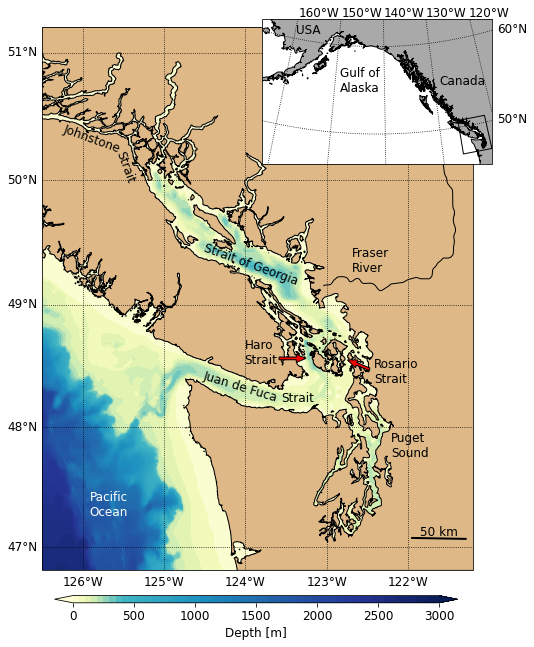

In [101]:
# ---------- Study Area Map -----------------
# Make figure
xlim, ylim = [-126.5, -121.2], [46.8, 51.2]
proj, proj_ref = crs.Mercator(np.mean(xlim), *ylim), crs.PlateCarree()
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': proj})

# ------------ Main Panel -------------------
# Map and projection
ax.set_extent(xlim + ylim)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='burlywood', zorder=0))
ax.add_feature(feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines', scale='10m', fc='none', ec='k', zorder=0
))
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True)
gl.top_labels, gl.right_labels = False, False

# Plot topography and add colorbar
c = ax.contourf(
    lon, lat, -depth, levels=np.arange(0, 3001, 50),
    cmap='YlGnBu', extend='both', transform=crs.PlateCarree(),
    zorder=-1, norm=colors.TwoSlopeNorm(vmin=0, vcenter=400, vmax=3000),
)

# Annotations
for ann in annotations:
    color = 'w' if ann['name'] == 'Pacific\nOcean' else 'k'
    ax.text(*ann['xy'], ann['name'], transform=ax.transAxes, rotation=ann['r'], fontdict={'color': color}, zorder=10)
    if ann['arrow'] is not None:
        ax.arrow(*ann['arrow'], width=0.005, head_width=0.015, ec='k', fc='r', transform=ax.transAxes, zorder=10)

# Scalebar
length = 50
x, y, proj_utm = get_scalebar_pos((0.92, 0.06))
dx = length * 1000 / 2
ax.plot([x - dx, x + dx], [y, y], transform=proj_utm, color='k', lw=2)
ax.text(x, y, f'{length} km', transform=proj_utm, ha='center', va='bottom', zorder=10)

# ------------- Map Inset -------------------
# Map and projection
xmap, ymap = [-161, -122], [45, 62]
ax = fig.add_axes([0.52, 0.59, 0.4, 0.4], projection=crs.LambertConformal(np.mean(xmap), np.mean(ymap)))
ax.set_extent(xmap + ymap)
ax.add_feature(feature.GSHHSFeature('low', edgecolor='k', facecolor='darkgray'))
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, x_inline=False, ylocs=range(50, 61, 10))
gl.bottom_labels, gl.left_labels = False, False
gl.xlabel_style, gl.ylabel_style = {'rotation': 0}, {'rotation': 0}

# Overlay labels and region box
ax.text(0.34, 0.50, 'Gulf of\nAlaska', transform=ax.transAxes)
ax.text(0.77, 0.55, 'Canada', transform=ax.transAxes)
ax.text(0.15, 0.90, 'USA', transform=ax.transAxes)
ax.add_patch(patches.Rectangle(
    (xlim[0], ylim[0]), int(np.diff(xlim)), int(np.diff(ylim)),
    transform=proj_ref, fill=False, ec='k', zorder=10,
))

# Add colorbar for model bathymetry
cax = fig.add_axes([0.16, 0.08, 0.7, 0.01])
fig.colorbar(c, cax=cax, ticks=np.arange(0, 3001, 500), orientation='horizontal', label='Depth [m]')
#fig.savefig('/home/bmoorema/Desktop/studyareamap.pdf', bbox_inches='tight')

In [28]:
lon, lat, bathy = [grid[var].values for var in ('longitude', 'latitude', 'bathymetry')]
fn = '/data/bmoorema/MEOPAR/rivers-climatology/rivers_daily_202108.nc'
fn = '/results/forcing/rivers/R202012DFraCElse_y2015m09d05.nc'
rivers = xr.open_dataset(fn)
runoff = rivers.rorunoff.values.reshape(1, -1).sum(axis=0) * 86400
romask = runoff != 0
runoff = np.log10(runoff[romask])
roij = [coord.ravel()[romask] for coord in np.meshgrid(rivers.x, rivers.y)]
lon_rivers, lat_rivers = [coord[tuple(roij[::-1])] for coord in (lon, lat)]

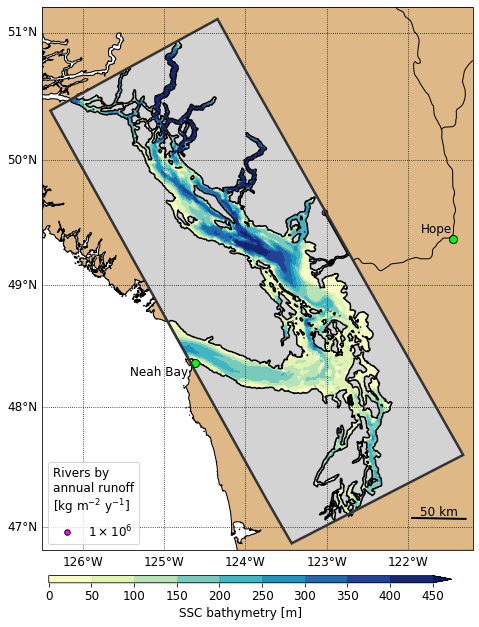

In [29]:
# ---------- Study Area Map -----------------
# Make figure
xlim, ylim = [-126.5, -121.2], [46.8, 51.2]
proj, proj_ref = crs.Mercator(np.mean(xlim), *ylim), crs.PlateCarree()
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': proj})

# ------------ Main Panel -------------------
# Map and projection
ax.set_extent(xlim + ylim)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='burlywood', zorder=0))
ax.add_feature(feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines', scale='10m', fc='none', ec='k', zorder=0
))
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True)
gl.top_labels, gl.right_labels = False, False

# Model domain
c = ax.contourf(lon, lat, bathy, levels=np.arange(0, 451, 50), cmap='YlGnBu', extend='max', transform=proj_ref)
ax.contourf(lon, lat, tmask, levels=[-0.01, 0.01], colors='lightgray', transform=proj_ref)
ax.contour(lon, lat, tmask, levels=[-0.01, 0.01], colors='k', transform=proj_ref)
ax.add_patch(patches.Polygon(make_polygon((0, -1, 0, -1)), fc='none', ec=[0.2, 0.2, 0.2], lw=2.5, transform=proj_ref, zorder=10))

# Plot rivers
sc = ax.scatter(lon_rivers, lat_rivers, s=(runoff-5)*30, c='magenta', edgecolors='k', transform=proj_ref)
        
# Neah Bay
x, y = -124.62, 48.36
ax.text(x-0.8, y-0.1, 'Neah Bay', transform=proj_ref)
ax.plot(x, y, 'ko', mfc='lime', ms=8, transform=proj_ref)

# Hope flow gauge
x, y = -121.44, 49.37
ax.text(x-0.4, y+0.05, 'Hope', transform=proj_ref)
ax.plot(x, y, 'ko', mfc='lime', ms=8, transform=proj_ref)

# Scalebar
length = 50
x, y, proj_utm = get_scalebar_pos((0.92, 0.06))
dx = length * 1000 / 2
ax.plot([x - dx, x + dx], [y, y], transform=proj_utm, color='k', lw=2)
ax.text(x, y, f'{length} km', transform=proj_utm, ha='center', va='bottom', zorder=10)

# Add colorbar for model bathymetry
cax = fig.add_axes([0.15, 0.08, 0.7, 0.01])
fig.colorbar(c, cax=cax, orientation='horizontal', label='SSC bathymetry [m]')

# Rivers legend
elements = sc.legend_elements(
    "sizes", fmt="$1\\times10^{{{x:d}}}$",
    color='magenta', mec='k',
    num=ticker.FixedLocator([6, 7, 8]),
    func=lambda x: x/30+5,
)
ax.legend(*elements, loc=3, title='Rivers by\nannual runoff\n[kg m$^{-2}$ y$^{-1}$]')
#fig.savefig('/home/bmoorema/Desktop/SSCdomainmap.pdf', bbox_inches='tight')